# Mini Lab 1
Group 2 
Members: Josh Mitchell, Adam Alidra, Ryan Herrin

### Requirements
- Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use. That is, the SGDClassifier is fine to use for optimizing logistic regression and linear support vector machines. For many problems, SGD will be required in order to train the SVM model in a reasonable timeframe.
- Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.
- Use the weights from logistic regression to interpret the importance of different features for the classification task. Explain your interpretation in detail. Why do you think some variables are more important?
- Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset.

## Setup 

In [1]:
# Libraries
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn import metrics as mt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
# Read in data 

# NOTE: Data imported has been generated from the first lab and turned into two data sets 
# + One data set is the raw data minus columns that had no values in them 
# + The other data set is data that had a transformation applied to it 
raw_data_location = '../dataset/raw_data.csv'
transformed_data_location = '../dataset/transformed_data.csv'

raw_data_df = pd.read_csv(raw_data_location)
tf_data_df = pd.read_csv(transformed_data_location) # tf being shorthand for transformed


## Logistic Regression Model and SVM Model

#### Split data into 80/20 Train Test 

In [3]:
# Define common random seed value and sample test percentage size 
seed_value = 8675309 # if you know you know
test_sample_size = .2 # percentage 

# Split the data into a 80/20 Train/Testing for raw and trasnformed data 
# Using the split method from sklearn 
raw_train, raw_test = train_test_split(raw_data_df, test_size=test_sample_size, random_state=seed_value)
tf_train, tf_test = train_test_split(tf_data_df, test_size=test_sample_size, random_state=seed_value)

# Create Reusable Numpy arrays from the raw and transformed data to avoid using loc and iloc to seperate
# the contents of the dataframes when training/testing

# Raw Data ---
raw_train_features = raw_train.iloc[:, 1:].to_numpy() # features to train without 'is_obf'
raw_train_labels = raw_train.loc[:, 'is_obf'].to_numpy() # only 'is_obf'
raw_test_features = raw_test.iloc[:, 1:].to_numpy() # features to create predictions
raw_test_labels = raw_test.loc[:, 'is_obf'].to_numpy() # only 'is_obf' to test accuracy and get matrix with

# Transformed Data ---
tf_train_features = tf_train.iloc[:, 1:].to_numpy() # features to train without 'is_obf'
tf_train_labels = tf_train.loc[:, 'is_obf'].to_numpy() # only 'is_obf'
tf_test_features = tf_test.iloc[:, 1:].to_numpy() # features to create predictions
tf_test_labels = tf_test.loc[:, 'is_obf'].to_numpy() # only 'is_obf' to test accuracy and get matrix with

### Logistic Regression Model

LogisticRegression() Notes:
- @penalty: L1 = Lasso Regression, L2 = Ridge Regression "Squared magnitude"
- @C: Float value. "Smaller values specify stronger regularzation"
- @class_weight: Weights associated with classes in the form {class_label: weight}
- @max_iter: default was 100, but 150 was needed 

Raw Data Logistic Regression

In [4]:
# Logistic Regression Model for Raw Data #

# Create Logistic Regression Object 
log_reg_raw = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='liblinear', max_iter=150)

# Train model with raw data input
log_reg_raw.fit(raw_train_features, raw_train_labels)

# Create predictions from model
raw_log_reg_pred = log_reg_raw.predict(raw_test_features)

# Get accuracy 
raw_log_reg_accuracy = mt.accuracy_score(
    raw_test_labels, # Original lables (classifications)
    raw_log_reg_pred # Predicted values
)

# Get confusion Matrix
raw_log_reg_conf = mt.confusion_matrix(raw_test_labels, raw_log_reg_pred)

# Display results
print("Accuracy: ", raw_log_reg_accuracy)
print("Confusion Matrix\n", raw_log_reg_conf)

Accuracy:  0.9629985583853916
Confusion Matrix
 [[ 614   26]
 [  51 1390]]


Transformed Data Logistic Regression

In [5]:
# Logistic Regression Model for Transformed Data 

# Create Logistic Regression Object 
log_reg_tf = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='liblinear', max_iter=150)

# Train model with raw data input
log_reg_tf.fit(tf_train_features, tf_train_labels)

# Create predictions from model
tf_log_reg_pred = log_reg_tf.predict(tf_test_features)

# Get accuracy 
tf_log_reg_accuracy = mt.accuracy_score(
    tf_test_labels, # Original lables (classifications)
    tf_log_reg_pred # Predicted values
)

# Get confusion Matrix
tf_log_reg_conf = mt.confusion_matrix(tf_test_labels, tf_log_reg_pred)

# Display results
print("Accuracy: ", tf_log_reg_accuracy)
print("Confusion Matrix\n", tf_log_reg_conf)

Accuracy:  0.9553099471407976
Confusion Matrix
 [[ 609   31]
 [  62 1379]]


### Logistic Regression Weight Interpretation

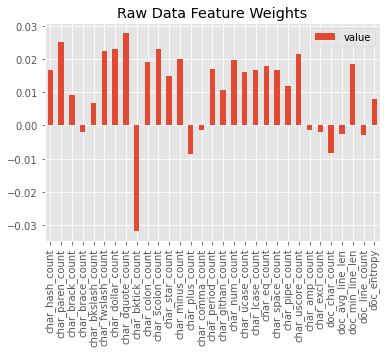


Feature Weights
---------------------
char_bktick_count weight:  -0.03164989108600169
char_plus_count weight:  -0.008722062783377765
doc_char_count weight:  -0.008256577513094096
doc_line_count weight:  -0.0028783623161697212
doc_avg_line_len weight:  -0.0024316392065223797
char_excl_count weight:  -0.002115552972305724
char_brace_count weight:  -0.001976555290790541
char_amp_count weight:  -0.0015051750854944276
char_comma_count weight:  -0.001253554911067075
char_carrot_count weight:  -0.00043275582416423577
doc_max_line_len weight:  -0.00030609546000275436
doc_dtype_float_word_count weight:  9.4270164154653e-10
doc_dtype_double_word_count weight:  7.55880428384928e-09
doc_dtype_decimal_word_count weight:  2.295081308796399e-08
doc_keyword_trap_word_count weight:  9.858128911420693e-08
doc_dtype_char_word_count weight:  1.3203843337635205e-07
doc_keyword_dynamicparam_word_count weight:  3.0094425990642196e-07
doc_dtype_long_word_count weight:  3.329414983165701e-07
doc_keyword_until

In [6]:
# Raw Data # 
# Graphical display of weights 
raw_logreg_weights = pd.DataFrame(log_reg_raw.coef_[0], columns=['value'], index=raw_train.iloc[:, 1:].columns)

# Since there are so many features with wieghts that are almost exactly zero, we will only 
# display those that have a weight greater than .001
raw_logreg_weights = raw_logreg_weights.loc[(raw_logreg_weights["value"] >= .001) | (raw_logreg_weights["value"] <= -.001)]

raw_logreg_weights.plot(kind='bar', title='Raw Data Feature Weights')
plt.show()

# Get the weights for each variable 
# sort these attributes and spit them out
raw_logreg_vars = zip(log_reg_raw.coef_.T, raw_train.iloc[:, 1:])
raw_logreg_vars = sorted(raw_logreg_vars)
# Display Weights 
print('\nFeature Weights\n---------------------')
for coef, name in raw_logreg_vars:
    print(name, 'weight: ', coef[0])

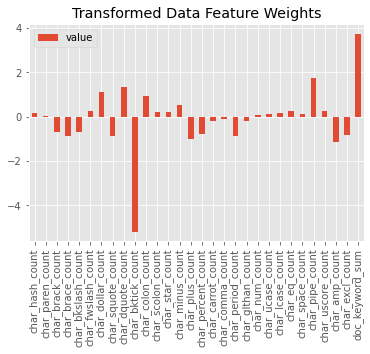


Feature Weights
---------------------
char_bktick_count weight:  -5.180133470250689
char_amp_count weight:  -1.1470676328264289
char_plus_count weight:  -1.0128240760699014
char_squote_count weight:  -0.8882056277368777
char_brace_count weight:  -0.8706667191172535
char_period_count weight:  -0.8597392512050249
char_excl_count weight:  -0.8284191807347966
char_percent_count weight:  -0.7919766195796991
char_brack_count weight:  -0.694828883973486
char_bkslash_count weight:  -0.6707975608886608
char_glthan_count weight:  -0.20695229026110692
char_carrot_count weight:  -0.18401555580292345
char_comma_count weight:  -0.11338066467028637
char_paren_count weight:  0.029193321738764873
char_num_count weight:  0.061869634270520155
char_space_count weight:  0.10669898919361266
char_ucase_count weight:  0.11831948127704567
char_hash_count weight:  0.18352265321574418
char_lcase_count weight:  0.1906051739445954
char_scolon_count weight:  0.20130384324533196
char_star_count weight:  0.214583620

In [7]:
# Transformed Data #
# Graphical display of weights from transformed data 
tf_logreg_weights = pd.DataFrame(log_reg_tf.coef_[0], columns=['value'], index=tf_train.iloc[:, 1:].columns)
tf_logreg_weights.plot(kind='bar', title='Transformed Data Feature Weights')
plt.show()

# Get the weights for each variable 
# sort these attributes and spit them out
tf_logreg_vars = zip(log_reg_tf.coef_.T, tf_train.iloc[:, 1:])
tf_logreg_vars = sorted(tf_logreg_vars)
# Display Weights 
print('\nFeature Weights\n---------------------')
for coef, name in tf_logreg_vars:
    print(name, 'weight: ', coef[0])

### SVM Model

Raw Data SVM

In [13]:
# SVM Model for Raw Data
svm_raw = SVC(C=0.5, kernel='linear', degree=3, gamma='auto') # Create SVM object
svm_raw.fit(raw_train_features, raw_train_labels) 

# Get the predictions 
raw_svm_pred = svm_raw.predict(raw_test_features) 

# Get accuracy 
raw_svm_accuracy = mt.accuracy_score(
    raw_test_labels, # Original lables (classifications)
    raw_svm_pred # Predicted values
)

# Get confusion Matrix
raw_svm_conf = mt.confusion_matrix(raw_test_labels, raw_svm_pred)

# Display results
print("Accuracy: ", raw_svm_accuracy)
print("Confusion Matrix\n", raw_svm_conf)

Accuracy:  0.964440172993753
Confusion Matrix
 [[ 598   42]
 [  32 1409]]


Transformed Data SVM

In [12]:
# SVM Model for Transformed Data
svm_tf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # Create SVM object
svm_tf.fit(tf_train_features, tf_train_labels) 

# Get the predictions 
tf_svm_pred = svm_tf.predict(tf_test_features) 

# Get accuracy 
tf_svm_accuracy = mt.accuracy_score(
    tf_test_labels, # Original lables (classifications)
    tf_svm_pred # Predicted values
)

# Get confusion Matrix
tf_svm_conf = mt.confusion_matrix(tf_test_labels, tf_svm_pred)

# Display results
print("Accuracy: ", tf_svm_accuracy)
print("Confusion Matrix\n", tf_svm_conf)

Accuracy:  0.9567515617491591
Confusion Matrix
 [[ 588   52]
 [  38 1403]]
